In [1]:
import pandas as pd

In [2]:
data=pd.read_csv("College_Admission.csv")

In [3]:
data

,student_id,age,gender,category,state,preferred_stream,entrance_exam,entrance_score,board_percentage,extracurricular_score,admission_probability,admission_status,scholarship_eligibility
0,250.99,17,other,general,odisha,management,cet,30,95.58,2,0.387,admitted,yes
1,250.99,20,other,ews,gujarat,agriculture,none,0,75.45,2,0.221,rejected,no
2,250.99,19,female,sc,uttar pradesh,pharmacy,cet,120,75.36,10,0.446,rejected,no
3,250.99,18,male,ews,meghalaya,arts,cet,179,52.49,2,0.174,admitted,no
4,250.99,18,male,sc,rajasthan,engineering,jee,295,92.48,7,0.634,admitted,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,24750.01,18,female,obc,uttar pradesh,law,none,0,82.67,2,0.273,rejected,no
24996,24750.01,20,other,ews,andhra pradesh,management,none,0,60.66,10,0.258,rejected,no
24997,24750.01,17,male,obc,manipur,pharmacy,cet,195,91.87,6,0.544,rejected,no
24998,24750.01,19,male,ews,andhra pradesh,management,cet,66,50.44,9,0.209,rejected,no


In [4]:
df=data.drop('student_id',axis=1)

In [5]:
df=data.drop('admission_status',axis=1)

In [6]:
df['category']=df['category'].replace({'general':'Gen','ews':'EWS','sc':'SC','st':'ST','obc':'OBC'})

In [7]:
df['gender']=df['gender'].replace({'female':'F','male':'M','other':'O'})

In [8]:
df['scholarship_eligibility']=df['scholarship_eligibility'].replace({'yes':1,'no':0})

C:\Users\Admin\AppData\Local\Temp\ipykernel_7344\2232884068.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['scholarship_eligibility']=df['scholarship_eligibility'].replace({'yes':1,'no':0})


In [9]:
df['admission'] = (df['admission_probability'] >= 0.5).astype(int)

In [10]:
y = df["admission"]
x = df.drop(columns=["admission"])

In [11]:
x_raw = x.copy() 

In [12]:
from sklearn.model_selection import train_test_split

x_train_raw, x_test_raw, y_train, y_test = train_test_split(x_raw, y,test_size=0.2, random_state=42)

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder( drop=None, sparse_output=False, handle_unknown="ignore")

In [14]:
cat_cols = [ "gender", "category", "state", "preferred_stream", "entrance_exam", "scholarship_eligibility" ]

In [15]:
num_cols = [col for col in x_train_raw.columns if col not in cat_cols]

In [16]:
x_train_cat = encoder.fit_transform(x_train_raw[cat_cols])
x_test_cat = encoder.transform(x_test_raw[cat_cols])

x_train_num = x_train_raw[num_cols].values
x_test_num = x_test_raw[num_cols].values

In [17]:
import numpy as np

In [18]:
x_train_enc = np.hstack([x_train_num, x_train_cat])
x_test_enc = np.hstack([x_test_num, x_test_cat])

In [19]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=2000)
lr.fit(x_train_enc, y_train)
y_prob_lr = lr.predict_proba(x_test_enc)[:, 1]
y_pred_lr = (y_prob_lr >= 0.5).astype(int)

D:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42,class_weight='balanced')
rf.fit(x_train_enc, y_train)
y_pred_rf = rf.predict(x_test_enc)

In [21]:
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("Logistic Regression CM:\n", cm_lr)
print("Random Forest CM:\n", cm_rf)


Logistic Regression CM:
 [[4402   37]
 [  48  513]]
Random Forest CM:
 [[4439    0]
 [   0  561]]


In [22]:
x_test_raw = x_test_raw.copy()
x_test_raw["y_true"] = y_test.values
x_test_raw["y_pred"] = y_pred_lr

In [23]:
def compute_fnr_fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    return fnr, fpr

In [24]:
results = []

for state in x_test_raw["state"].unique():
    subset = x_test_raw[x_test_raw["state"] == state]
    fnr, fpr = compute_fnr_fpr(subset["y_true"], subset["y_pred"])
    results.append([state, fnr, fpr])

import pandas as pd

state_fairness_lr = pd.DataFrame(results, columns=["state", "FNR", "FPR"])

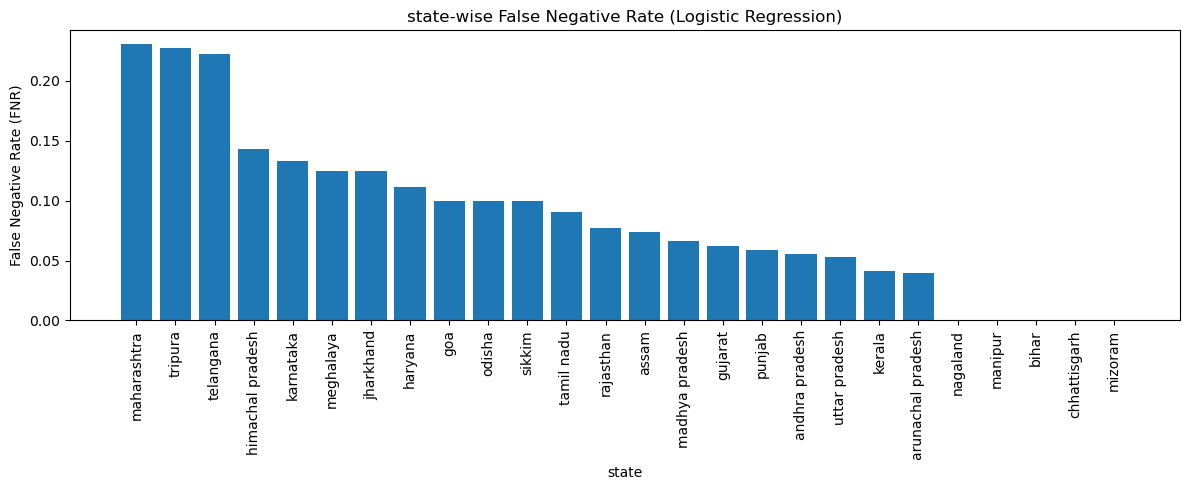

In [25]:
import matplotlib.pyplot as plt

state_fnr_sorted = state_fairness_lr.sort_values("FNR", ascending=False)

plt.figure(figsize=(12,5))
plt.bar(state_fnr_sorted["state"], state_fnr_sorted["FNR"])
plt.xticks(rotation=90)
plt.ylabel("False Negative Rate (FNR)")
plt.xlabel("state")
plt.title("state-wise False Negative Rate (Logistic Regression)")
plt.tight_layout()
plt.show()

In [26]:
gender_fairness = (x_test_raw.groupby("gender")["y_pred"].mean().reset_index(name="Admission Rate"))

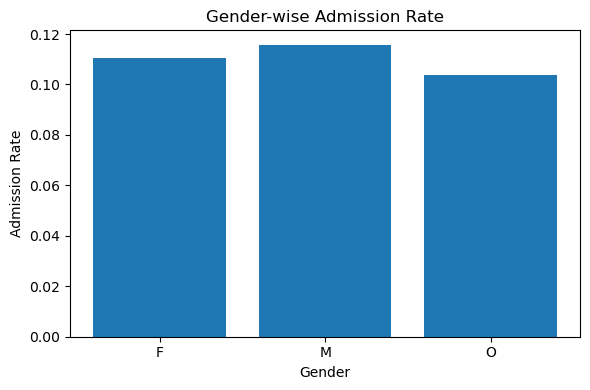

In [27]:
plt.figure(figsize=(6,4))
plt.bar(gender_fairness["gender"], gender_fairness["Admission Rate"])
plt.ylabel("Admission Rate")
plt.xlabel("Gender")
plt.title("Gender-wise Admission Rate")
plt.tight_layout()
plt.show()

In [28]:
category_fairness = (x_test_raw.groupby("category")["y_pred"].mean().reset_index(name="Admission Rate"))
category_fairness

,category,Admission Rate
0,EWS,0.116208
1,Gen,0.116371
2,OBC,0.112195
3,SC,0.105740
4,ST,0.099291


In [29]:
from sklearn.metrics import accuracy_score

acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", acc_lr)

Logistic Regression Accuracy: 0.983


In [30]:
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", acc_rf)

Random Forest Accuracy: 1.0


In [31]:
accuracy_table = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Accuracy": [acc_lr, acc_rf]
})

accuracy_table


,Model,Accuracy
0,Logistic Regression,0.983
1,Random Forest,1.000


In [32]:
gender_results = []

for g in x_test_raw["gender"].unique():
    subset = x_test_raw[x_test_raw["gender"] == g]
    fnr, fpr = compute_fnr_fpr(subset["y_true"], subset["y_pred"])
    gender_results.append([g, fnr, fpr])

gender_fairness_lr = pd.DataFrame(gender_results,columns=["Gender", "FNR", "FPR"])
gender_fairness_lr

,Gender,FNR,FPR
0,M,0.063492,0.011425
1,F,0.094241,0.004202
2,O,0.099448,0.009192


In [33]:
category_results = []

for c in x_test_raw["category"].unique():
    subset = x_test_raw[x_test_raw["category"] == c]
    fnr, fpr = compute_fnr_fpr(subset["y_true"], subset["y_pred"])
    category_results.append([c, fnr, fpr])

category_fairness_lr = pd.DataFrame(category_results, columns=["Category", "FNR", "FPR"])
category_fairness_lr

,Category,FNR,FPR
0,ST,0.104762,0.004535
1,SC,0.067961,0.010112
2,OBC,0.075000,0.004420
3,Gen,0.036697,0.014365
4,EWS,0.137097,0.008168


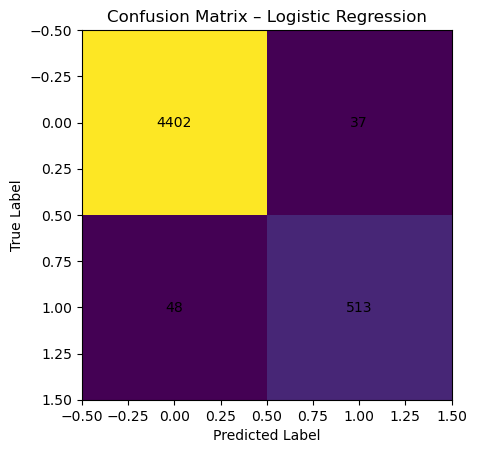

In [34]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.imshow(cm_lr)
plt.title("Confusion Matrix – Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_lr[i, j], ha="center", va="center")

plt.show()

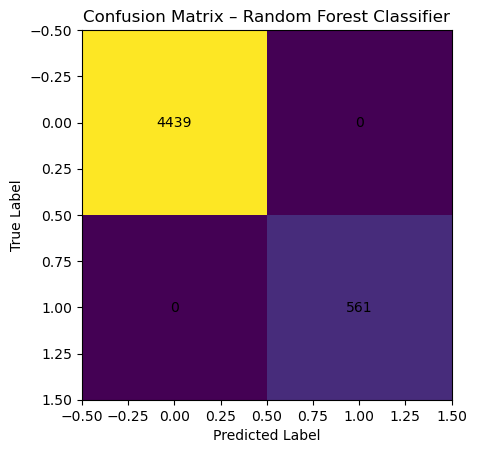

In [35]:
plt.figure()
plt.imshow(cm_rf)
plt.title("Confusion Matrix – Random Forest Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_rf[i, j], ha="center", va="center")

plt.show()

In [36]:
def compute_fnr_fpr(y_true, y_pred):
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    tp = np.sum((y_true == 1) & (y_pred == 1))

    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    return fnr, fpr

In [37]:
results = []

for state in x_test_raw['state'].unique():
    idx = x_test_raw['state'] == state
    fnr, fpr = compute_fnr_fpr(y_test[idx], y_pred_lr[idx])
    results.append({'State': state, 'FNR': fnr, 'FPR': fpr})

state_fairness_lr = pd.DataFrame(results)
state_fairness_lr = state_fairness_lr.sort_values('FNR', ascending=False)
state_fairness_lr


,State,FNR,FPR
3,maharashtra,0.230769,0.000000
18,tripura,0.227273,0.013423
9,telangana,0.222222,0.023529
1,himachal pradesh,0.142857,0.012195
22,karnataka,0.133333,0.000000
7,meghalaya,0.125000,0.000000
14,jharkhand,0.125000,0.005495
16,haryana,0.111111,0.000000
13,goa,0.100000,0.013245
20,odisha,0.100000,0.000000


In [38]:
state_results = []

for state in x_test_raw["state"].unique():
    subset = x_test_raw[x_test_raw["state"] == state]
    fnr, fpr = compute_fnr_fpr(subset["y_true"], subset["y_pred"])
    state_results.append([state, fnr, fpr])

In [39]:
state_fairness_lr = pd.DataFrame(state_results,columns=["State", "FNR", "FPR"])
state_fairness_lr

,State,FNR,FPR
0,arunachal pradesh,0.040000,0.011834
1,himachal pradesh,0.142857,0.012195
2,chhattisgarh,0.000000,0.006494
3,maharashtra,0.230769,0.000000
4,kerala,0.041667,0.032680
5,sikkim,0.100000,0.011364
6,madhya pradesh,0.066667,0.020548
7,meghalaya,0.125000,0.000000
8,assam,0.074074,0.005435
9,telangana,0.222222,0.023529


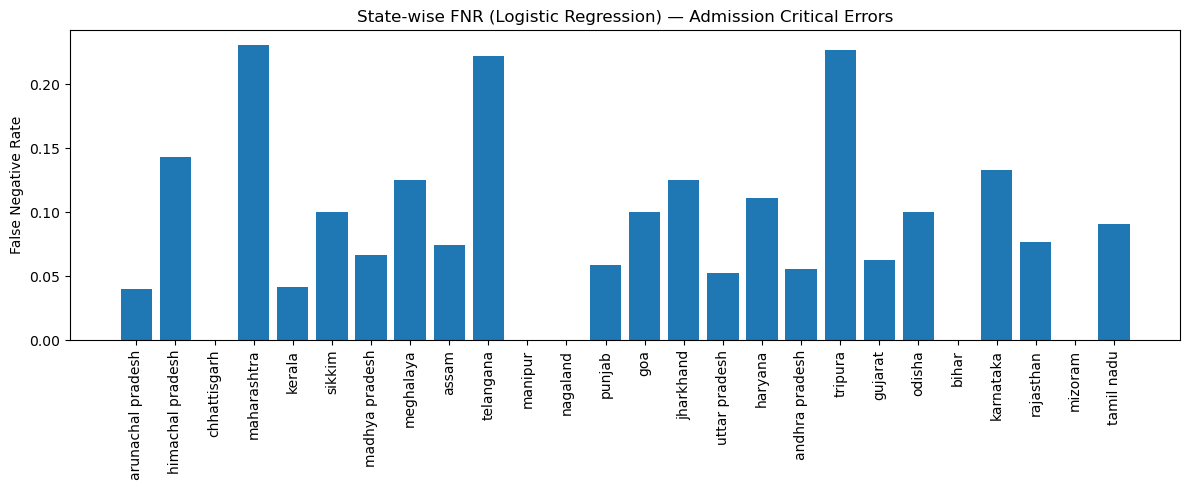

In [40]:
plt.figure(figsize=(12,5))
plt.bar(state_fairness_lr['State'], state_fairness_lr['FNR'])
plt.xticks(rotation=90)
plt.ylabel("False Negative Rate")
plt.title("State-wise FNR (Logistic Regression) — Admission Critical Errors")
plt.tight_layout()
plt.show()

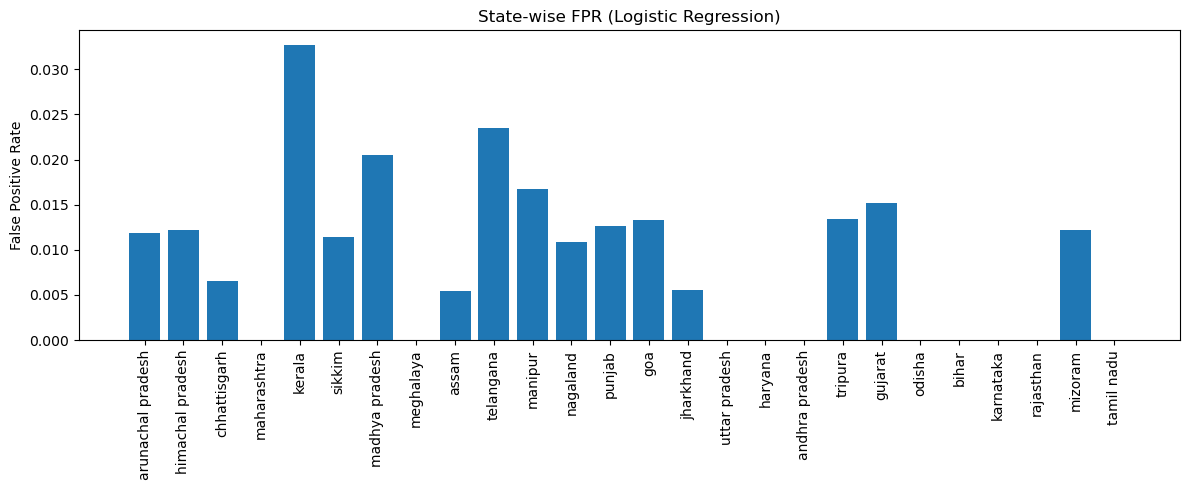

In [41]:
plt.figure(figsize=(12,5))
plt.bar(state_fairness_lr['State'], state_fairness_lr['FPR'])
plt.xticks(rotation=90)
plt.ylabel("False Positive Rate")
plt.title("State-wise FPR (Logistic Regression)")
plt.tight_layout()
plt.show()